In [16]:
#city coords
def get_coord_dict(name,lat, long):
    return {'name': name, 'lat': lat, 'long': long}

## Miami
miami_lat = 25.753811
miami_long = -80.384102
miami_coords = get_coord_dict("miami", miami_lat, miami_long)

## NYC
nyc_lat = 40.785091
nyc_long = -73.968285
nycq_coords = get_coord_dict("nyc", nyc_lat, nyc_long)

## Chicago
chicago_lat = 41.78499686
chicago_long = -87.751496994
chicago_coords = get_coord_dict("chicago", chicago_lat, chicago_long)

## Austin
austin_lat = 30.18999924
austin_long = -97.668663992
austin_coords = get_coord_dict("austin", austin_lat, austin_long)

In [17]:
# Turn coords into a json file
import json
with open('../data/city_coords.json', 'w') as f:
    json.dump([miami_coords, nycq_coords, chicago_coords, austin_coords], f)

In [3]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": austin_lat,
	"longitude": austin_long,
	"daily": "temperature_2m_max",
	"temperature_unit": "fahrenheit",
	"past_days": 1,
	"forecast_days": 0
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)



Coordinates 30.189205169677734°N -97.66046142578125°E
Elevation 149.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                        date  temperature_2m_max
0  2023-12-04 00:00:00+00:00           67.874901
1  2023-12-05 00:00:00+00:00           72.014900
2  2023-12-06 00:00:00+00:00           69.854897
3  2023-12-07 00:00:00+00:00           71.834900
4  2023-12-08 00:00:00+00:00           73.184898
..                       ...                 ...
87 2024-02-29 00:00:00+00:00           52.394901
88 2024-03-01 00:00:00+00:00           67.514900
89 2024-03-02 00:00:00+00:00           79.934898
90 2024-03-03 00:00:00+00:00           79.214897
91 2024-03-04 00:00:00+00:00           81.914902

[92 rows x 2 columns]


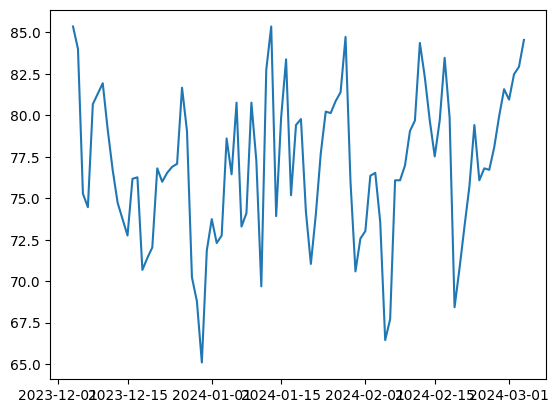

In [14]:
import matplotlib.pyplot as plt

# Plot daily temperature
plt.plot(daily_dataframe["date"], daily_dataframe["temperature_2m_max"], label = "Max temperature")

In [14]:
import requests

url = "https://meteostat.p.rapidapi.com/point/daily"

querystring = {"lat":miami_lat,"lon":miami_long,"start":"2024-02-03","end":"2024-02-13", "freq": "D", "units": "imperial"}

headers = {
	"X-RapidAPI-Key": "4206659d56mshb5302695c124972p113f70jsn9a7bf0b5758b",
	"X-RapidAPI-Host": "meteostat.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

{'meta': {'generated': '2024-03-05 19:58:36', 'stations': ['72202', 'KTMB0', 'JY84X', 'KHST0']}, 'data': [{'date': '2024-02-03', 'tavg': 67.8, 'tmin': 57.0, 'tmax': 78.1, 'prcp': 0.0, 'snow': 0.0, 'wdir': 156.0, 'wspd': 5.2, 'wpgt': None, 'pres': 1011.4, 'tsun': 0}, {'date': '2024-02-04', 'tavg': 69.6, 'tmin': 62.1, 'tmax': 75.0, 'prcp': 0.728, 'snow': 0.0, 'wdir': 169.0, 'wspd': 8.7, 'wpgt': None, 'pres': 1004.8, 'tsun': 0}, {'date': '2024-02-05', 'tavg': 64.4, 'tmin': 60.1, 'tmax': 68.0, 'prcp': 0.13, 'snow': 0.0, 'wdir': 334.0, 'wspd': 4.5, 'wpgt': None, 'pres': 1001.2, 'tsun': 0}, {'date': '2024-02-06', 'tavg': 61.2, 'tmin': 57.0, 'tmax': 71.1, 'prcp': 0.0, 'snow': 0.0, 'wdir': 315.0, 'wspd': 11.9, 'wpgt': None, 'pres': 1006.9, 'tsun': 0}, {'date': '2024-02-07', 'tavg': 63.9, 'tmin': 55.9, 'tmax': 77.0, 'prcp': 0.0, 'snow': 0.0, 'wdir': 352.0, 'wspd': 8.7, 'wpgt': None, 'pres': 1017.3, 'tsun': 0}, {'date': '2024-02-08', 'tavg': 67.1, 'tmin': 59.0, 'tmax': 77.0, 'prcp': 0.0, 'snow':

In [6]:
import requests

url = "https://meteostat.p.rapidapi.com/stations/nearby"

querystring = {"lat":miami_lat,"lon":miami_long}

headers = {
	"X-RapidAPI-Key": "4206659d56mshb5302695c124972p113f70jsn9a7bf0b5758b",
	"X-RapidAPI-Host": "meteostat.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

{'meta': {'generated': '2024-03-05 19:48:11'}, 'data': [{'id': '72202', 'name': {'en': 'Miami International Airport'}, 'distance': 7503.5}, {'id': 'KTMB0', 'name': {'en': 'Miami / Country Walk'}, 'distance': 12747.6}, {'id': 'KHST0', 'name': {'en': 'Homestead / Homestead Base'}, 'distance': 29512.4}, {'id': 'KHWO0', 'name': {'en': 'Hollywood / Pembroke Pines'}, 'distance': 31024.8}, {'id': '74783', 'name': {'en': 'Fort Lauderdale'}, 'distance': 42333.8}, {'id': 'KFXE0', 'name': {'en': 'Fort Lauderdale / Twin Lakes (Historical)'}, 'distance': 53729.9}, {'id': 'KPMP0', 'name': {'en': 'Pompano Beach / Kendall Green'}, 'distance': 61262.4}, {'id': 'KBCT0', 'name': {'en': 'Boca Raton / Floresta'}, 'distance': 74747.8}, {'id': 'KLNA0', 'name': {'en': 'Lantana / Lake Osborne Trailer Ranch'}, 'distance': 97978.6}]}


In [30]:
import requests

# NOAA API endpoint
base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

# NOAA API token (replace with your own token)
token = "JBQpkZPOHcTNCeSktiRLnsnjLfhgAgWy"

# Parameters for the API request
params = {
    "datasetid": "GHCND",
    "locationid": "CITY:US120001",
    "startdate": "2024-02-01",
    "enddate": "2024-02-04",
    "datatypeid": "TMAX",
    "limit": 1000,  
    "units": "standard"
}

# Headers for the API request
headers = {
    "token": token
}

# Make the API request
response = requests.get(base_url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Process the retrieved data
    for record in data["results"]:
        date = record["date"]
        max_temp = record["value"]
        print(f"Date: {date}, Maximum Temperature: {max_temp}°F")
else:
    print("Failed to retrieve data from the NOAA API.")

Date: 2024-02-01T00:00:00, Maximum Temperature: 68.0°F
Date: 2024-02-03T00:00:00, Maximum Temperature: 73.0°F
Date: 2024-02-03T00:00:00, Maximum Temperature: 72.0°F
Date: 2024-02-04T00:00:00, Maximum Temperature: 74.0°F
Date: 2024-02-04T00:00:00, Maximum Temperature: 64.0°F


In [35]:
import requests

longitude = -122.4194
latitude = 37.7749
start_date = "20240301"
end_date = "20240304"

params = {
    "parameters": "T2M_MAX",
    "community": "RE",
    "longitude": longitude,
    "latitude": latitude,
    "start": start_date,
    "end": end_date,
    "format": "JSON"
}

# Set the base URL for the NASA POWER API
base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"

# Make the API request
response = requests.get(base_url, params=params)

# Function to convert Celsius to Fahrenheit
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    temperatures = data["properties"]["parameter"]["T2M_MAX"]
    
    # Process the temperature data
    for date, value in temperatures.items():
        celsius = float(value)
        fahrenheit = celsius_to_fahrenheit(celsius)
        print(f"Date: {date}, Maximum Temperature: {fahrenheit:.2f}°F")
else:
    print("Failed to retrieve temperature data.")

Date: 20240301, Maximum Temperature: 53.62°F
Date: 20240302, Maximum Temperature: 51.42°F
Date: 20240303, Maximum Temperature: -1766.20°F
Date: 20240304, Maximum Temperature: -1766.20°F
